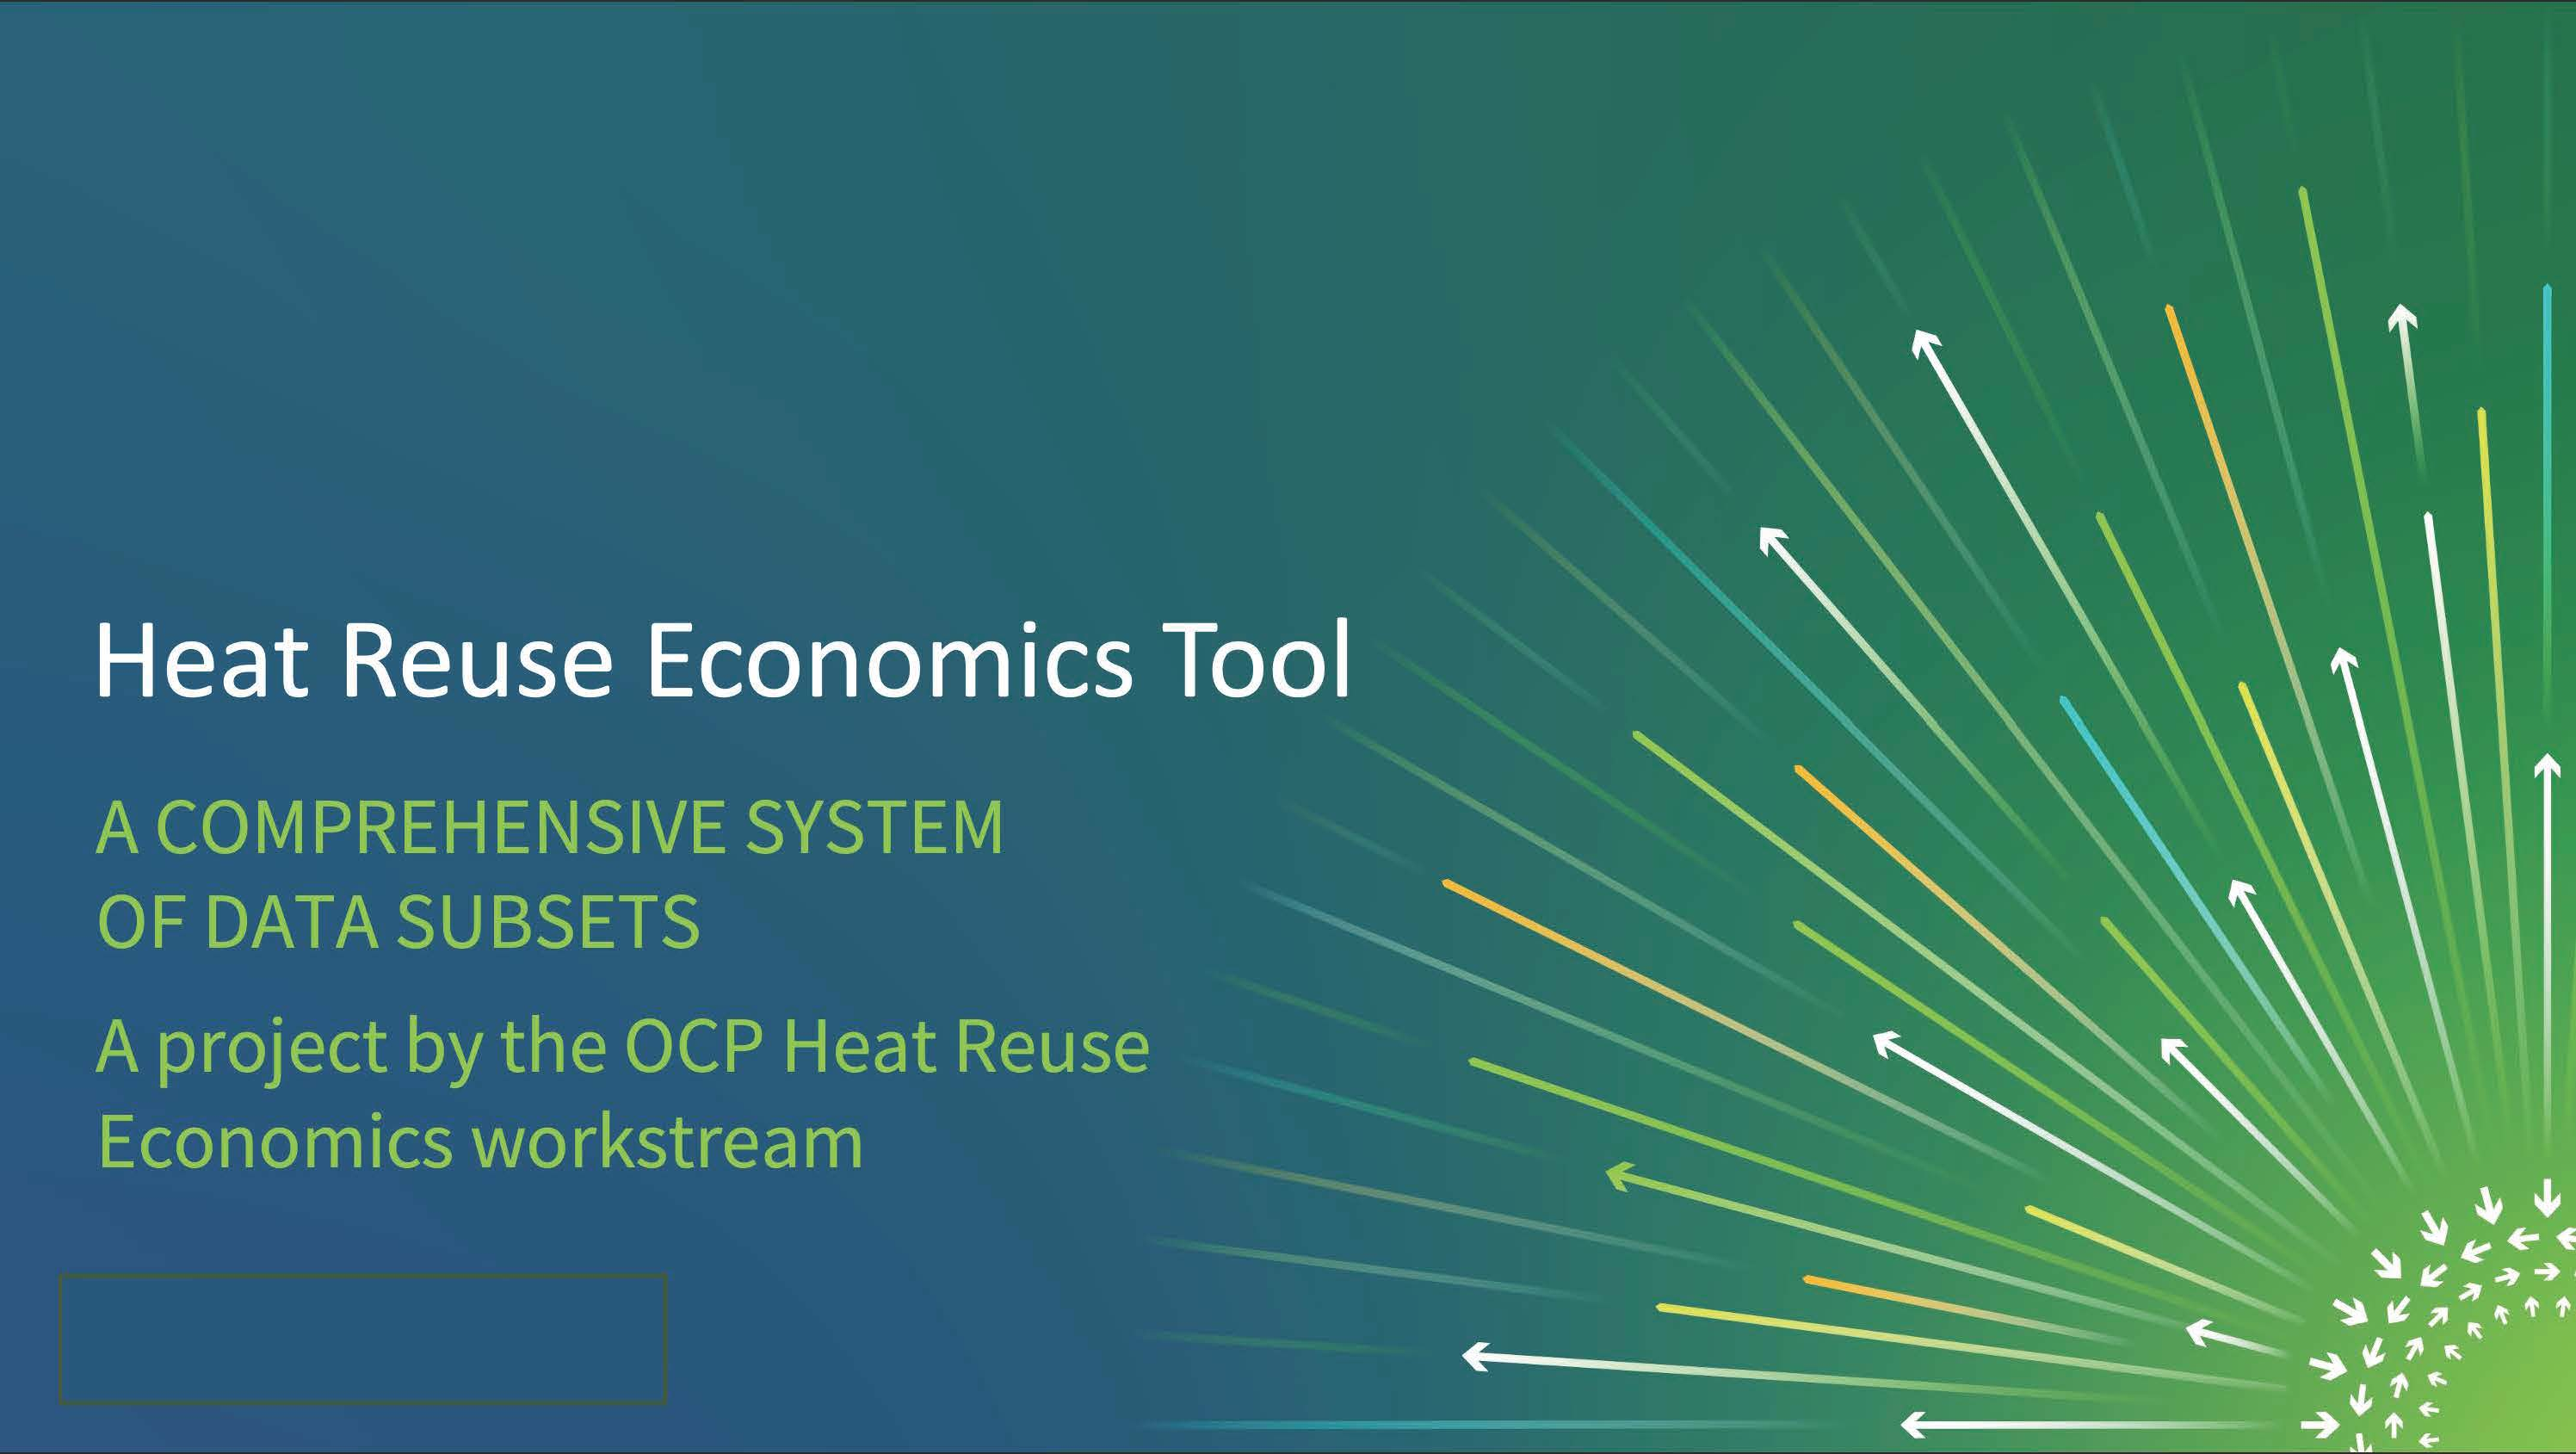

In [371]:
from IPython.display import Image, display
import os

# Display the logo image from the Assets directory
image_path = os.path.join("Assets", "HeatReuseEconomicsTool_Horizontal.jpg")

# Display the image with appropriate sizing
display(Image(filename=image_path, width=600))

# Interactive Analysis Tool

## User Guide

This notebook provides an easy-to-use interface for running calculations based on temperature and flow inputs.

### Instructions:
1. Run the setup cell below by clicking the ▶️ button or pressing Shift+Enter
2. Enter your values for temperatures (T1-T4) and flows (F1-F2) in the input fields
3. Click the "Run Calculation" button to process the data
4. View the results and visualizations below the button

**Note:** If you encounter any errors, please ensure all input values are numbers.

In [372]:
# Import required libraries
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
import re
import pandas as pd
import math
import os
from datetime import datetime
from pathlib import Path
from IPython.display import display, clear_output, HTML


# Set up plotting configuration
%matplotlib inline
plt.style.use('ggplot')



In [373]:
# universal_float_convert - FIXED VERSION

def universal_float_convert(value):
    """
    CORRECTED European-priority universal number parser
    Handles both American and European CSV data formats correctly
    
    Key fix: Properly detects American thousands separators (comma + exactly 3 digits)
    vs European decimal separators
    """
    
    # Handle None, NaN, and empty values
    if value is None:
        return 0.0
    
    try:
        if pd.isna(value):
            return 0.0
    except (TypeError, ValueError):
        pass
    
    # Handle numeric types that are already numbers
    if isinstance(value, (int, float)):
        if math.isnan(value) or math.isinf(value):
            return 0.0
        return float(value)
    
    # Convert to string and clean
    try:
        str_val = str(value).strip()
    except (UnicodeError, AttributeError):
        return 0.0
    
    # Handle empty string
    if not str_val:
        return 0.0
    
    # Handle special text cases
    special_cases = {
        'nan', 'none', 'null', 'n/a', 'na', '#n/a', '#value!', '#ref!', 
        '#div/0!', '#num!', 'inf', '-inf', 'infinity', '-infinity',
        'true', 'false', 'yes', 'no', 'error', 'err',
        'nichts', 'nul', 'erreur', 'infinito', 'niets', 'ingen'
    }
    if str_val.lower() in special_cases:
        return 0.0
    
    # Store original
    original_str = str_val
    
    # Handle scientific notation early
    scientific_patterns = [
        r'^-?[\d,]+\.?\d*[eE][+-]?\d+$',  # Standard: 1.5e3, 1,5e3
    ]
    for pattern in scientific_patterns:
        if re.match(pattern, str_val):
            try:
                sci_val = str_val.replace(',', '.')
                return float(sci_val)
            except (ValueError, OverflowError):
                continue
    
    # Handle percentage
    is_percentage = False
    if '%' in str_val:
        is_percentage = True
        str_val = str_val.replace('%', '')
    
    # Remove currency symbols
    currency_pattern = r'[$€£¥₹₽¢₦₪₨₩₫₡₵₸₴₺₼CHF|USD|EUR|GBP]'
    str_val = re.sub(currency_pattern, '', str_val, flags=re.IGNORECASE)
    
    # Remove text words
    text_patterns = [
        r'\b(ca\.?|etwa|circa|environ|ongeveer)\b',
        r'[()[\]{}"\']',
    ]
    for pattern in text_patterns:
        str_val = re.sub(pattern, '', str_val, flags=re.IGNORECASE)
    
    # Clean whitespace
    str_val = ' '.join(str_val.split())
    
    # Keep only numbers, separators, and signs
    str_val = re.sub(r'[^\d.,\s+\-\']', '', str_val).strip()
    
    if not str_val:
        return 0.0
    
    # Handle sign
    is_negative = False
    if str_val.startswith('-'):
        is_negative = True
        str_val = str_val[1:].strip()
    elif str_val.startswith('+'):
        str_val = str_val[1:].strip()
    
    if not str_val:
        return 0.0
    
    try:
        result = None
        
        # STRATEGY 1: Simple cases (no ambiguity)
        if re.match(r'^\d+$', str_val):
            # Pure integer: 123
            result = float(str_val)
            
        # STRATEGY 2: Clear multi-separator patterns (unambiguous)
        elif re.match(r'^\d{1,3}(\.\d{3})+,\d+$', str_val):
            # German: 1.234.567,89 (dots=thousands, comma=decimal)
            result = float(str_val.replace('.', '').replace(',', '.'))
            
        elif re.match(r'^\d{1,3}(\s\d{3})+,\d+$', str_val):
            # French: 1 234 567,89 (spaces=thousands, comma=decimal)
            result = float(str_val.replace(' ', '').replace(',', '.'))
            
        elif re.match(r'^\d{1,3}(\'\d{3})+\.\d+$', str_val):
            # Swiss: 1'234'567.89 (apostrophes=thousands, dot=decimal)
            result = float(str_val.replace('\'', ''))
            
        elif re.match(r'^\d{1,3}(,\d{3})+\.\d+$', str_val):
            # American with decimal: 1,234,567.89 (commas=thousands, dot=decimal)
            result = float(str_val.replace(',', ''))
            
        # STRATEGY 3: Thousands-only patterns (no decimal part)
        elif re.match(r'^\d{1,3}(\.\d{3})+$', str_val):
            # German thousands: 1.234.567
            result = float(str_val.replace('.', ''))
            
        elif re.match(r'^\d{1,3}(\s\d{3})+$', str_val):
            # French thousands: 1 234 567
            result = float(str_val.replace(' ', ''))
            
        elif re.match(r'^\d{1,3}(\'\d{3})+$', str_val):
            # Swiss thousands: 1'234'567
            result = float(str_val.replace('\'', ''))
            
        elif re.match(r'^\d{1,3}(,\d{3})+$', str_val):
            # American thousands: 1,234,567 OR single group like 1,493
            result = float(str_val.replace(',', ''))
            
        # STRATEGY 4: Single separator - IMPROVED LOGIC
        elif re.match(r'^\d+[.,]\d+$', str_val):
            # Single separator - need to determine if thousands or decimal
            if ',' in str_val:
                parts = str_val.split(',')
                integer_part = parts[0]
                fractional_part = parts[1]
                
                # KEY FIX: Check for American thousands pattern first
                if len(fractional_part) == 3 and len(integer_part) <= 4:
                    # AMERICAN THOUSANDS: 1,493 or 12,345 (comma + exactly 3 digits)
                    # This is definitely a thousands separator, not decimal
                    result = float(integer_part + fractional_part)
                    print(f"🔍 Detected American thousands: {str_val} → {result}")
                elif len(fractional_part) <= 2:
                    # European decimal: 1,5 or 123,45 (comma + 1-2 digits)
                    result = float(integer_part + '.' + fractional_part)
                    print(f"🔍 Detected European decimal: {str_val} → {result}")
                elif len(fractional_part) > 3:
                    # 4+ digits after comma: definitely decimal (European style)
                    result = float(integer_part + '.' + fractional_part)
                    print(f"🔍 Detected European long decimal: {str_val} → {result}")
                else:
                    # Fallback for edge cases
                    result = float(integer_part + fractional_part)  # Treat as thousands
                    
            else:  # '.' in str_val
                parts = str_val.split('.')
                integer_part = parts[0]
                fractional_part = parts[1]
                
                # For dots, similar logic but reversed priorities
                if len(fractional_part) == 3 and len(integer_part) >= 2:
                    # Could be European thousands: 12.345
                    # But could also be American decimal: 12.345
                    # Check if integer part suggests thousands (longer numbers)
                    if len(integer_part) >= 4:
                        # Likely European thousands: 1234.567 → 1234567
                        result = float(integer_part + fractional_part)
                        print(f"🔍 Detected European thousands: {str_val} → {result}")
                    else:
                        # Likely American decimal: 12.345
                        result = float(str_val)
                        print(f"🔍 Detected American decimal: {str_val} → {result}")
                elif len(fractional_part) <= 2:
                    # Standard decimal: 12.34
                    result = float(str_val)
                    print(f"🔍 Detected standard decimal: {str_val} → {result}")
                else:
                    # Default to decimal for unclear cases
                    result = float(str_val)
        
        # STRATEGY 5: Mixed separators (both . and ,)
        elif '.' in str_val and ',' in str_val:
            last_dot = str_val.rfind('.')
            last_comma = str_val.rfind(',')
            
            if last_comma > last_dot:
                # Comma is last = decimal separator (European)
                before = str_val[:last_comma].replace('.', '').replace(',', '').replace(' ', '').replace('\'', '')
                after = str_val[last_comma + 1:]
                result = float(f"{before}.{after}")
                print(f"🔍 Detected European mixed format: {str_val} → {result}")
            else:
                # Dot is last = decimal separator (American)
                before = str_val[:last_dot].replace('.', '').replace(',', '').replace(' ', '').replace('\'', '')
                after = str_val[last_dot + 1:]
                result = float(f"{before}.{after}")
                print(f"🔍 Detected American mixed format: {str_val} → {result}")
        
        # STRATEGY 6: Fallback
        else:
            # Try to extract just the digits
            digits_only = re.sub(r'[^\d]', '', str_val)
            if digits_only:
                result = float(digits_only)
                print(f"🔍 Fallback digits only: {str_val} → {result}")
            else:
                return 0.0
        
        # Apply transformations
        if is_negative and result is not None:
            result = -result
        
        if is_percentage and result is not None:
            result = result / 100.0
        
        # Validate result
        if result is None or math.isnan(result) or math.isinf(result):
            return 0.0
            
        return result
        
    except (ValueError, TypeError, OverflowError):
        # Final fallback
        try:
            digits_only = re.sub(r'[^\d]', '', original_str)
            if digits_only:
                fallback = float(digits_only)
                if is_negative:
                    fallback = -fallback
                if is_percentage:
                    fallback = fallback / 100.0
                return fallback
            else:
                return 0.0
        except:
            return 0.0

In [374]:
# AllHX_Data

def lookup_allhx_data(power, t1, temp_diff, approach):
    """
    ALLHX lookup using proper data filtering and type consistency
    
    Args:
        power: System power in MW
        t1: Inlet temperature in °C
        temp_diff: Temperature difference in °C  
        approach: Approach value
    
    Returns:
        System data dictionary or None if not found
    """
    global csv_data
    
    t2 = t1 + temp_diff
    
    if 'ALLHX' not in csv_data:
        print("Error: ALLHX.csv not loaded")
        return None
    
    df = csv_data['ALLHX'].copy()
    
    print(f"ALLHX lookup: Power={power}, T1={t1}, TempDiff={temp_diff}, T2={t2}, Approach={approach}")
    
    # Clean data - remove header rows
    df = df[df['wha'].astype(str).str.strip() != 'A']
    df = df[df['wha'].astype(str).str.strip() != 'wha']
    
    # Convert to consistent numeric types
    numeric_columns = ['wha', 'T1', 'itdt', 'T2', 'TCSapp', 'F1', 'F2', 'T3', 'T4', 
                       'FWSapp', 'costHX', 'areaHX', 'Hxweight', 'CO2_Footprint']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: float(universal_float_convert(x)))
    
    # Remove invalid rows
    valid_df = df[(df['wha'] > 0) & (df['T1'] > 0) & (df['itdt'] > 0) & (df['TCSapp'] > 0)]
    
    print(f"Valid data rows: {len(valid_df)}")
    
    if len(valid_df) == 0:
        print("No valid data after conversion")
        return None
    
    # Show available combinations for debugging
    print(f"Available combinations:")
    print(f"  Power (wha): {sorted(valid_df['wha'].unique())}")
    print(f"  T1: {sorted(valid_df['T1'].unique())}")
    print(f"  TempDiff (itdt): {sorted(valid_df['itdt'].unique())}")
    print(f"  Approach (TCSapp): {sorted(valid_df['TCSapp'].unique())}")
    
    # Convert inputs to float for consistent comparison
    power = float(power)
    t1 = float(t1)
    temp_diff = float(temp_diff)
    t2 = float(t2)
    approach = float(approach)
    
    # Exact match filtering
    filtered_df = valid_df[
        (valid_df['wha'] == power) & 
        (valid_df['T1'] == t1) & 
        (valid_df['itdt'] == temp_diff) & 
        (valid_df['T2'] == t2) & 
        (valid_df['TCSapp'] == approach)
    ]
    
    print(f"Exact matches found: {len(filtered_df)}")
    
    if filtered_df.empty:
        print(f"No exact match found for specified parameters")
        return None
    
    # Get first matching row
    row = filtered_df.iloc[0]
    
    result = {
        'power': power,
        'T1': t1,
        'T2': t2,
        'T3': row['T3'],
        'T4': row['T4'],
        'F1': row['F1'],
        'F2': row['F2'],
        'approach_tcs': approach,
        'approach_fws': row['FWSapp'] if 'FWSapp' in row else 0.0,
        'hx_unit': str(row['Unit']) if 'Unit' in row else '',
        'hx_cost': row['costHX'] if 'costHX' in row else 0.0,
        'hx_area': row['areaHX'] if 'areaHX' in row else 0.0,
        'hx_weight': row['Hxweight'] if 'Hxweight' in row else 0.0,
        'co2_footprint': row['CO2_Footprint'] if 'CO2_Footprint' in row else 0.0
    }
    
    print(f"Match found: F1={result['F1']}, F2={result['F2']}, HX_Cost=€{result['hx_cost']}")
    
    return result


In [375]:
# Lookup Functions


def get_system_sizing(system_data):
    """
    CORRECTED: Now uses get_PipeSize_Suggested formula function
    """
    if not system_data:
        return None
    
    # Use formula functions for pipe sizing
    pipe_size_f1 = get_PipeSize_Suggested(system_data['F1'])
    pipe_size_f2 = get_PipeSize_Suggested(system_data['F2'])
    
    # Get room size based on power using existing ROOM lookup
    room_size = None
    if 'ROOM' in csv_data:
        room_df = csv_data['ROOM'].copy()
        # Convert columns to numeric
        room_df.iloc[:, 0] = room_df.iloc[:, 0].apply(universal_float_convert)  # Power column
        room_df.iloc[:, 1] = room_df.iloc[:, 1].apply(universal_float_convert)  # Room size column
        
        for idx, row in room_df.iterrows():
            power_val = row.iloc[0]
            if power_val >= system_data['power']:
                room_size = row.iloc[1]
                break
    
    sizing_data = {
        'pipe_size_f1': pipe_size_f1 or 100,  # Default fallback
        'pipe_size_f2': pipe_size_f2 or 100,
        'room_size': room_size or 12.5,
        'primary_pipe_size': max(pipe_size_f1 or 100, pipe_size_f2 or 100)
    }
    
    return sizing_data

def calculate_system_costs(system_data, sizing_data):
    """
    CORRECTED: Now uses formula functions for all calculations
    """
    if not system_data or not sizing_data:
        return None
    
    # Get flow rates for formula calculations
    F1 = system_data['F1']
    F2 = system_data['F2']
    T1 = system_data['T1']
    T2 = system_data['T2']
    
    # CORRECTED: Use get_PipeLength formula instead of hardcoded calculation
    total_pipe_length = get_PipeLength(F1, T1, T2)
    
    # CORRECTED: Use get_PipeCost_perMeter formula instead of direct CSV lookup
    pipe_cost_per_meter = get_PipeCost_perMeter(F1, "sched40")
    
    # CORRECTED: Use get_PipeCost_Total formula for total pipe cost
    total_pipe_cost = get_PipeCost_Total(F1, T1, T2, "sched40")
    
    # Calculate valve costs using formula-determined pipe size
    primary_pipe_size = get_PipeSize_Suggested(max(F1, F2))  # Use formula function
    
    control_valve_cost = 0
    isolation_valve_cost = 0
    
    if 'CVALV' in csv_data:
        cvalv_df = csv_data['CVALV'].copy()
        # Convert cost column to numeric
        cvalv_df.iloc[:, 1] = cvalv_df.iloc[:, 1].apply(universal_float_convert)
        
        # Look for exact match on pipe size
        pipe_size_str = str(int(primary_pipe_size))
        for idx, row in cvalv_df.iterrows():
            if str(row.iloc[0]).strip() == pipe_size_str:
                control_valve_cost = row.iloc[1]
                break
    
    if 'IVALV' in csv_data:
        ivalv_df = csv_data['IVALV'].copy()
        # Convert cost column to numeric
        ivalv_df.iloc[:, 1] = ivalv_df.iloc[:, 1].apply(universal_float_convert)
        
        # Look for exact match on pipe size
        pipe_size_str = str(int(primary_pipe_size))
        for idx, row in ivalv_df.iterrows():
            if str(row.iloc[0]).strip() == pipe_size_str:
                isolation_valve_cost = row.iloc[1]
                break
    
    total_valve_cost = (control_valve_cost + isolation_valve_cost) * 4  # 4 of each type
    
    # Other costs
    hx_cost = system_data['hx_cost']
    pump_cost = system_data['power'] * 5000  # Estimated
    installation_cost = 10000  # Placeholder
    total_cost = total_pipe_cost + total_valve_cost + hx_cost + pump_cost + installation_cost
    
    cost_data = {
        'pipe_cost_per_meter': pipe_cost_per_meter,
        'total_pipe_length': total_pipe_length,
        'total_pipe_cost': total_pipe_cost,
        'control_valve_cost': control_valve_cost,
        'isolation_valve_cost': isolation_valve_cost,
        'total_valve_cost': total_valve_cost,
        'hx_cost': hx_cost,
        'pump_cost': pump_cost,
        'installation_cost': installation_cost,
        'total_cost': total_cost
    }
    
    return cost_data

def get_complete_system_analysis(power, t1, temp_diff, approach):
    """
    CORRECTED: Complete system analysis using formula functions
    """
    print(f"\n🔧 COMPLETE SYSTEM ANALYSIS")
    print(f"Input: {power}MW, {t1}°C, +{temp_diff}°C, approach {approach}")
    
    # Step 1: Get system data from ALLHX
    system_data = lookup_allhx_data(power, t1, temp_diff, approach)
    if not system_data:
        print("ALLHX lookup failed")
        return None
    
    print("✅ ALLHX lookup successful")
    
    # Step 2: Calculate sizing using corrected formula functions
    sizing_data = get_system_sizing(system_data)
    if not sizing_data:
        print("System sizing failed")
        return None
    
    print("✅ System sizing successful")
    
    # Step 3: Calculate costs using corrected formula functions
    cost_data = calculate_system_costs(system_data, sizing_data)
    if not cost_data:
        print("Cost calculation failed")
        return None
    
    print("✅ Cost calculation successful")
    
    # Additional validation using formulas
    F1 = system_data['F1']
    F2 = system_data['F2']
    T1 = system_data['T1']
    T2 = system_data['T2']
    T3 = system_data['T3']
    T4 = system_data['T4']
    
    # Validate calculations using formula functions
    calculated_mw = get_MW_divd(F1, T1, T2)
    delta_t_tcs = get_DeltaT_TCS(T1, T2)
    delta_t_fws = get_DeltaT_FWS(T3, T4)
    approach_calc = get_Approach(T1, T4)
    
    print(f"Formula validation:")
    print(f"  Calculated MW: {calculated_mw}")
    print(f"  Delta T TCS: {delta_t_tcs}°C")
    print(f"  Delta T FWS: {delta_t_fws}°C")
    print(f"  Approach: {approach_calc}")
    
    # Combine all data
    complete_analysis = {
        'system': system_data,
        'sizing': sizing_data,
        'costs': cost_data,
        'validation': {
            'calculated_mw': calculated_mw,
            'delta_t_tcs': delta_t_tcs,
            'delta_t_fws': delta_t_fws,
            'approach_calculated': approach_calc
        },
        'summary': {
            'power_mw': system_data['power'],
            't1_celsius': system_data['T1'],
            't2_celsius': system_data['T2'],
            't3_celsius': system_data['T3'],
            't4_celsius': system_data['T4'],
            'f1_flow': system_data['F1'],
            'f2_flow': system_data['F2'],
            'pipe_size': sizing_data['primary_pipe_size'],
            'room_size': sizing_data['room_size'],
            'total_cost_eur': round(cost_data['total_cost'])
        }
    }
    
    return complete_analysis

def validate_user_inputs(power, t1, temp_diff, approach):
    """
    PRODUCTION VERSION: Validate user inputs
    """
    errors = []
    
    if power not in [1, 2, 3, 4, 5]:
        errors.append(f"Power must be 1, 2, 3, 4, or 5 MW (got {power})")
    
    if t1 not in [20, 30, 45]:
        errors.append(f"T1 must be 20, 30, or 45°C (got {t1})")
    
    if temp_diff not in [10, 12, 14]:
        errors.append(f"Temperature difference must be 10, 12, or 14°C (got {temp_diff})")
    
    if approach not in [2, 3, 5]:
        errors.append(f"Approach must be 2, 3, or 5 (got {approach})")
    
    return errors

In [376]:
# Formulas

def get_MW_divd(F1, T1, T2):
    """Calculate MW with proper error handling"""
    try:
        mw_value = get_MW(F1, T1, T2)
        if mw_value is None:
            print(f"⚠️ get_MW returned None for F1={F1}, T1={T1}, T2={T2}")
            return 0.0
        result = mw_value / 1000000
        rounded = round(result, 2)
        return rounded
    except Exception as e:
        print(f"❌ Error in get_MW_divd: {e}")
        return 0.0

def get_DeltaT_TCS(T1, T2):
    """Calculate TCS temperature difference"""
    try:
        return float(T2) - float(T1)
    except Exception as e:
        print(f"❌ Error in get_DeltaT_TCS: {e}")
        return 0.0

def get_DeltaT_FWS(T3, T4):
    """Calculate FWS temperature difference"""
    try:
        return float(T4) - float(T3)
    except Exception as e:
        print(f"❌ Error in get_DeltaT_FWS: {e}")
        return 0.0

def get_Approach(T1, T4):
    """Calculate approach temperature"""
    try:
        return float(T4) - float(T1)
    except Exception as e:
        print(f"❌ Error in get_Approach: {e}")
        return 0.0

def get_PipeSize_Suggested(F1):
    """
    CORRECTED: Get suggested pipe size using CEILING lookup (engineering safe)
    Returns the SMALLEST pipe size that can handle the flow (size >= required)
    """
    try:
        F1_float = float(F1)
        
        print(f"🔍 CEILING lookup for pipe size: flow F1={F1_float}")
        
        # Check if PIPSZ data exists
        if 'PIPSZ' not in csv_data:
            print("❌ PIPSZ CSV not found")
            return 100  # Default fallback
        
        # Get and examine PIPSZ data
        pipsz_df = csv_data['PIPSZ'].copy()
        print(f"📊 PIPSZ data shape: {pipsz_df.shape}")
        
        # Convert columns to numeric
        pipsz_df.iloc[:, 0] = pipsz_df.iloc[:, 0].apply(universal_float_convert)  # Flow capacity
        pipsz_df.iloc[:, 1] = pipsz_df.iloc[:, 1].apply(universal_float_convert)  # Pipe size
        
        # Remove invalid rows
        valid_rows = pipsz_df.dropna()
        
        # Sort by flow capacity to ensure we find the smallest adequate size
        valid_rows = valid_rows.sort_values(by=valid_rows.columns[0])
        
        flow_values = valid_rows.iloc[:, 0]
        print(f"📊 Available flow capacities: min={flow_values.min()}, max={flow_values.max()}")
        print(f"📊 First few flow/size pairs: {list(zip(flow_values.head(), valid_rows.iloc[:, 1].head()))}")
        
        # CEILING LOOKUP: Find the SMALLEST flow capacity that is >= F1
        # This ensures the pipe can safely handle the required flow
        candidates = valid_rows[valid_rows.iloc[:, 0] >= F1_float]
        
        if not candidates.empty:
            # Get the smallest adequate pipe (first row after sorting)
            selected_flow = candidates.iloc[0, 0]
            selected_size = candidates.iloc[0, 1]
            print(f"✅ CEILING match found: Flow capacity {selected_flow} >= {F1_float} → Pipe Size {selected_size}")
            print(f"🔧 Engineering validation: Pipe can handle {selected_flow} l/m >= required {F1_float} l/m ✓")
            return float(selected_size)
        else:
            # If even the largest pipe is too small, use the largest available
            max_flow_row = valid_rows.loc[valid_rows.iloc[:, 0].idxmax()]
            max_flow = max_flow_row.iloc[0]
            max_size = max_flow_row.iloc[1]
            print(f"⚠️ Required flow {F1_float} exceeds largest available capacity {max_flow}")
            print(f"⚠️ Using largest available pipe size: {max_size} (ENGINEERING REVIEW NEEDED)")
            return float(max_size)
        
    except Exception as e:
        print(f"❌ Error in get_PipeSize_Suggested: {e}")
        return 100  # Default fallback

def get_MW(F1, T1, T2):
    """Calculate power in watts"""
    try:
        # F1 = l/m, T1 and T2 in Celsius
        F1_float = float(F1)
        T1_float = float(T1)
        T2_float = float(T2)
        
        itdt = get_DeltaT_TCS(T1_float, T2_float)
        # l/m / 60 seconds * 4186 J/kg*K * delta_T
        formula = F1_float / 60 * 4186 * itdt
        
        print(f"🔍 MW calculation: F1={F1_float} l/m, ΔT={itdt}°C → {formula} W")
        return formula
    except Exception as e:
        print(f"❌ Error in get_MW: {e}")
        return 0.0

def get_PipeLength(F1, T1, T2):
    """
    CORRECTED: Calculate pipe length using CEILING lookup for room size
    Uses the SMALLEST room that can accommodate the power requirement
    """
    try:
        print(f"🔍 CEILING lookup for pipe length: F1={F1}, T1={T1}, T2={T2}")
        
        # Get MW value
        mw = get_MW_divd(F1, T1, T2)
        print(f"🔍 Calculated power requirement: {mw} MW")
        
        if mw <= 0:
            print("⚠️ Power is 0 or negative, using default length")
            return 37.5  # Default reasonable length
        
        # Check ROOM data
        if 'ROOM' not in csv_data:
            print("❌ ROOM CSV not found, using default length")
            return 37.5
        
        # Get room data
        room_df = csv_data['ROOM'].copy()
        print(f"📊 ROOM data shape: {room_df.shape}")
        
        # Convert to numeric
        room_df.iloc[:, 0] = room_df.iloc[:, 0].apply(universal_float_convert)  # Power capacity
        room_df.iloc[:, 1] = room_df.iloc[:, 1].apply(universal_float_convert)  # Room length
        
        # Remove invalid rows and sort by power capacity
        valid_rooms = room_df.dropna().sort_values(by=room_df.columns[0])
        
        power_values = valid_rooms.iloc[:, 0]
        print(f"📊 Available room power capacities: {list(power_values)}")
        
        # CEILING LOOKUP: Find the SMALLEST room that can accommodate the power
        adequate_rooms = valid_rooms[valid_rooms.iloc[:, 0] >= mw]
        
        if not adequate_rooms.empty:
            selected_power = adequate_rooms.iloc[0, 0]
            selected_length = adequate_rooms.iloc[0, 1]
            print(f"✅ CEILING match: Room capacity {selected_power} MW >= required {mw} MW → Length {selected_length} m")
            print(f"🔧 Engineering validation: Room can handle {selected_power} MW >= required {mw} MW ✓")
            return float(selected_length)
        else:
            # Use the largest available room
            max_power_row = valid_rooms.loc[valid_rooms.iloc[:, 0].idxmax()]
            max_power = max_power_row.iloc[0]
            max_length = max_power_row.iloc[1]
            print(f"⚠️ Required power {mw} MW exceeds largest room capacity {max_power} MW")
            print(f"⚠️ Using largest available room: {max_length} m (ENGINEERING REVIEW NEEDED)")
            return float(max_length)
        
    except Exception as e:
        print(f"❌ Error in get_PipeLength: {e}")
        return 37.5  # Default fallback

def get_PipeCost_perMeter(F1, pipetype="sched40"):
    """
    CORRECTED: Calculate pipe cost per meter using CEILING lookup for pipe size
    Uses the cost for the SMALLEST pipe size that can handle the flow
    """
    try:
        print(f"🔍 CEILING lookup for pipe cost: F1={F1}, type={pipetype}")
        
        # Get pipe size using corrected ceiling lookup
        pipe_size = get_PipeSize_Suggested(F1)
        print(f"🔍 Determined pipe size (ceiling lookup): {pipe_size}")
        
        if pipe_size is None:
            print("❌ get_PipeSize_Suggested returned None")
            return 100.0  # Default cost
        
        # Get column index for pipe type
        column_index = get_pipetype_enum(pipetype)
        print(f"🔍 Pipe type column index: {column_index}")
        
        # Check PIPCOST data
        if 'PIPCOST' not in csv_data:
            print("❌ PIPCOST CSV not found")
            return 100.0
        
        pipcost_df = csv_data['PIPCOST'].copy()
        print(f"📊 PIPCOST data shape: {pipcost_df.shape}")
        
        # Convert to numeric
        pipcost_df.iloc[:, 0] = pipcost_df.iloc[:, 0].apply(universal_float_convert)  # Size
        pipcost_df.iloc[:, column_index] = pipcost_df.iloc[:, column_index].apply(universal_float_convert)  # Cost
        
        # Remove invalid rows and sort by size
        valid_costs = pipcost_df.dropna().sort_values(by=pipcost_df.columns[0])
        
        size_values = valid_costs.iloc[:, 0]
        print(f"📊 Available pipe sizes: {sorted(list(size_values))}")
        
        # CEILING LOOKUP: Find the SMALLEST size that is >= required pipe size
        adequate_sizes = valid_costs[valid_costs.iloc[:, 0] >= pipe_size]
        
        if not adequate_sizes.empty:
            selected_size = adequate_sizes.iloc[0, 0]
            selected_cost = adequate_sizes.iloc[0, column_index]
            print(f"✅ CEILING match: Size {selected_size} >= required {pipe_size} → Cost {selected_cost}")
            print(f"🔧 Engineering validation: Using size {selected_size} >= required {pipe_size} ✓")
            return float(selected_cost)
        else:
            # Use the largest available size
            max_size_row = valid_costs.loc[valid_costs.iloc[:, 0].idxmax()]
            max_size = max_size_row.iloc[0]
            max_cost = max_size_row.iloc[column_index]
            print(f"⚠️ Required size {pipe_size} exceeds largest available {max_size}")
            print(f"⚠️ Using largest available size: {max_size} → Cost {max_cost} (ENGINEERING REVIEW NEEDED)")
            return float(max_cost)
        
    except Exception as e:
        print(f"❌ Error in get_PipeCost_perMeter: {e}")
        return 100.0

def get_PipeCost_Total(F1, T1, T2, pipetype="sched40"):
    """Calculate total pipe cost with improved error handling"""
    try:
        print(f"🔍 Calculating total pipe cost for F1={F1}, T1={T1}, T2={T2}, type={pipetype}")
        
        # Get cost per meter (uses ceiling lookup)
        cost_per_meter = get_PipeCost_perMeter(F1, pipetype)
        print(f"🔍 Cost per meter (ceiling lookup): {cost_per_meter}")
        
        # Get pipe length (uses ceiling lookup)
        pipe_length = get_PipeLength(F1, T1, T2)
        print(f"🔍 Pipe length (ceiling lookup): {pipe_length}")
        
        # Validate both values
        if cost_per_meter is None:
            print("⚠️ Cost per meter is None, using default")
            cost_per_meter = 100.0
        
        if pipe_length is None:
            print("⚠️ Pipe length is None, using default")
            pipe_length = 37.5
        
        total_cost = float(cost_per_meter) * float(pipe_length)
        print(f"✅ Total pipe cost: {cost_per_meter} * {pipe_length} = {total_cost}")
        
        return total_cost
        
    except Exception as e:
        print(f"❌ Error in get_PipeCost_Total: {e}")
        return 3750.0  # Default reasonable total

def get_pipetype_enum(pipetype="carbon steel"):
    """Convert pipe type specification to integer enumeration with validation"""
    try:
        # Normalize pipetype parameter to column index
        if isinstance(pipetype, (int, float)):
            column_index = int(pipetype)
        else:
            pipetype_lower = str(pipetype).lower().replace(" ", "").replace("_", "")
            
            carbon_variations = [
                "carbonsteel", "carbonsteeel", "sched40", "schedule40", 
                "carbon", "steel", "cs", "sch40"
            ]
            
            stainless_variations = [
                "stainless", "stainlesssteel", "stainlesssteeel", "ss", "inox"
            ]
            
            if pipetype_lower in carbon_variations:
                column_index = 1
            elif pipetype_lower in stainless_variations:
                column_index = 2
            else:
                print(f"⚠️ Unrecognized pipe type '{pipetype}', defaulting to carbon steel")
                column_index = 1
        
        # Validate column index
        if column_index not in [1, 2]:
            print(f"⚠️ Invalid column index {column_index}, defaulting to carbon steel (1)")
            column_index = 1
        
        return column_index
    except Exception as e:
        print(f"❌ Error in get_pipetype_enum: {e}")
        return 1  # Default to carbon steel

def get_outputside_enum(outputside="client"):
    """Convert heat exchanger output side specification to integer enumeration"""
    try:
        if isinstance(outputside, (int, float)):
            side_index = int(outputside)
        else:
            outputside_lower = str(outputside).lower().replace(" ", "").replace("_", "").replace("-", "")
            
            it_client_variations = [
                "client", "it", "tcs", "server", "compute", "datacenter", "rack", "equipment",
                "primary", "hot", "source", "load", "process", "tubeside", "tube",
                "hotside", "hotsource", "heatload", "processside", "serverside",
                "tc", "dcs", "srv", "comp"
            ]
            
            heat_consumer_variations = [
                "heat", "fws", "consumer", "district", "building", "community", "export",
                "secondary", "cold", "cooling", "sink", "utility", "shellside", "shell",
                "coldside", "coolant", "heatsink", "utilization", "recovery", "reuse",
                "districtHeating", "wasteheat", "heatrecovery", "heatexport",
                "fw", "dist", "util", "cool"
            ]
            
            if outputside_lower in it_client_variations:
                side_index = 1
            elif outputside_lower in heat_consumer_variations:
                side_index = 2
            else:
                print(f"⚠️ Unrecognized output side '{outputside}', defaulting to client/IT side")
                side_index = 1
        
        if side_index not in [1, 2]:
            print(f"⚠️ Invalid side index {side_index}, defaulting to client/IT side (1)")
            side_index = 1
        
        return side_index
    except Exception as e:
        print(f"❌ Error in get_outputside_enum: {e}")
        return 1


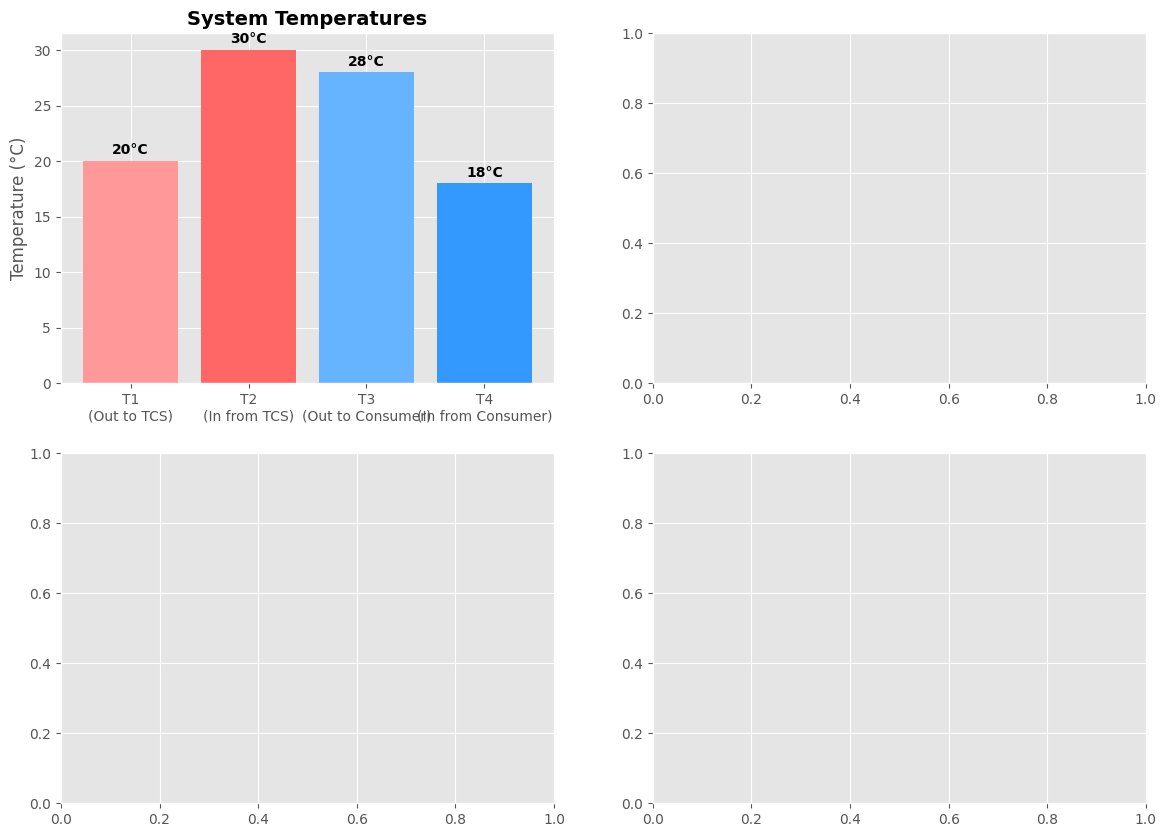

In [377]:
# Interface Setup and Widget Creation

from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Create the header
# display(HTML("""
# <div style="background-color: #f0f0f0; padding: 15px; border-radius: 8px; margin-bottom: 15px;">
#     <h3 style="margin-top: 0; color: #333;">🔧 System Configuration</h3>
#     <p style="margin-bottom: 0; color: #666;">Select system parameters from the dropdowns below, then click "Calculate System"</p>
# </div>
# """))

# Create dropdown widgets with the exact values from the specifications
style = {'description_width': '140px'}
layout = widgets.Layout(width='300px')

# A. Power/Capacity dropdown (1, 2, 3, 4, 5)
power_widget = widgets.Dropdown(
    options=[1, 2, 3, 4, 5],
    value=1,
    description='Power/Capacity:',
    tooltip='System power capacity in MW',
    style=style,
    layout=layout
)

# B. T1 Temperature dropdown (20, 30, 45)
t1_widget = widgets.Dropdown(
    options=[20, 30, 45],
    value=20,
    description='T1 Temperature:',
    tooltip='T1 outlet temperature in °C',
    style=style,
    layout=layout
)

# C. Temperature Rise dropdown (10, 12, 14)
temp_diff_widget = widgets.Dropdown(
    options=[10, 12, 14],
    value=10,
    description='Temperature Rise:',
    tooltip='Temperature difference (T2 - T1) in °C',
    style=style,
    layout=layout
)

# E. Approach dropdown (2, 3, 5)
approach_widget = widgets.Dropdown(
    options=[2, 3, 5],
    value=2,
    description='Approach:',
    tooltip='System approach value',
    style=style,
    layout=layout
)

# Create output areas for results
system_params_output = widgets.Output()
cost_analysis_output = widgets.Output()
charts_output = widgets.Output()

# Calculate System button
calculate_button = widgets.Button(
    description='Calculate System',
    button_style='success',
    tooltip='Calculate system parameters and costs',
    icon='calculator',
    layout=widgets.Layout(width='200px', height='45px', margin='10px 0')
)

# print("Widgets created successfully!")

In [378]:
# Dictionary to store all dataframes
csv_data = {}

# Function to get a specific dataframe
def get_dataframe(csv_name):
    """
    Get a specific dataframe by name.
    
    Parameters:
    csv_name (str): Name of the CSV file (case-insensitive)
    
    Returns:
    pandas.DataFrame: The dataframe, or None if not found
    """
    global csv_data
    
    # Normalize the CSV name
    csv_name = csv_name.upper()
    
    # Check if the CSV has been loaded
    if csv_name not in csv_data:
        print(f"CSV '{csv_name}' not found. Available CSVs: {list(csv_data.keys())}")
        return None
    
    return csv_data[csv_name]

def load_csv_files(data_dir="Data"):
    """
    Load all CSV files from the specified directory.
    
    Parameters:
    data_dir (str): Path to the directory containing CSV files
    
    Returns:
    dict: Dictionary of dataframes with normalized names as keys
    """
    global csv_data
    
    try:
        # Get all CSV files in the directory
        csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
        
        # Load each CSV file into a dataframe
        for file in csv_files:
            # Create a normalized name for the dataframe (without .csv extension, uppercase)
            df_name = os.path.splitext(file)[0].upper()
            file_path = os.path.join(data_dir, file)
            
            try:
                # Try to read the CSV file
                csv_data[df_name] = pd.read_csv(file_path)
                print(f"Loaded: {file} as {df_name}")
            except Exception as e:
                # Try with different separators if automatic detection fails
                try:
                    csv_data[df_name] = pd.read_csv(file_path, sep=';')
                    print(f"Loaded: {file} as {df_name} (using semicolon separator)")
                except:
                    try:
                        csv_data[df_name] = pd.read_csv(file_path, sep='\t')
                        print(f"Loaded: {file} as {df_name} (using tab separator)")
                    except Exception as e2:
                        print(f"Failed to load {file}: {e2}")
        
        return csv_data
    
    except Exception as e:
        print(f"Error loading CSV files: {e}")
        return {}

def get_lookup_value(csv_name, lookup_value, col_index_lookup=0, col_index_return=1):
    """
    Look up a value in a CSV file based on finding the first value 
    in col_index_lookup that is >= lookup_value, then return the 
    corresponding value from col_index_return.
    
    Parameters:
    csv_name (str): Name of the CSV file (case-insensitive)
    lookup_value: Value to look up (will be compared against col_index_lookup)
    col_index_lookup (int): Index of column to search in (default: 0)
    col_index_return (int/str/list): Index of column(s) to return value from (default: 1)
                                    Can be an integer, column name, or list of integers/names
    
    Returns:
    The value from col_index_return corresponding to the first row where
    col_index_lookup >= lookup_value, or None if not found.
    If col_index_return is a list, returns a dictionary with column names/indices as keys.
    """
    global csv_data
    
    # Normalize the CSV name
    csv_name = csv_name.upper()
    
    # Check if the CSV has been loaded
    if csv_name not in csv_data:
        print(f"CSV '{csv_name}' not found. Available CSVs: {list(csv_data.keys())}")
        return None
    
    # Get the dataframe
    df = csv_data[csv_name]
    
    # Get column name for lookup column
    lookup_col = df.columns[col_index_lookup] if isinstance(col_index_lookup, int) else col_index_lookup
    
    # Sort the dataframe by the lookup column to ensure proper comparison
    df_sorted = df.sort_values(by=lookup_col)
    
    # Find rows where lookup column >= lookup_value
    matching_rows = df_sorted[df_sorted[lookup_col] >= lookup_value]
    
    # If no matching rows, return None
    if matching_rows.empty:
        return None
    
    # Get the first matching row (which will be the smallest value >= lookup_value)
    matched_row = matching_rows.iloc[0]
    
    # Handle different return column specifications
    if isinstance(col_index_return, (list, tuple)):
        # Return multiple columns as a dictionary
        result = {}
        for col in col_index_return:
            col_name = df.columns[col] if isinstance(col, int) else col
            if col_name in df.columns:
                result[col_name] = matched_row[col_name]
            else:
                print(f"Warning: Column '{col_name}' not found in '{csv_name}'")
        return result
    else:
        # Return a single column
        return_col = df.columns[col_index_return] if isinstance(col_index_return, int) else col_index_return
        if return_col in df.columns:
            return matched_row[return_col]
        else:
            print(f"Column '{return_col}' not found in '{csv_name}'. Available columns: {list(df.columns)}")
            return None

def get_lookup_value_by_name(csv_name, lookup_value, lookup_col_name, return_col_name):
    """
    Look up a value in a CSV file based on finding the first value 
    in lookup_col_name that is >= lookup_value, then return the 
    corresponding value from return_col_name.
    
    Parameters:
    csv_name (str): Name of the CSV file (case-insensitive)
    lookup_value: Value to look up (will be compared against lookup_col_name)
    lookup_col_name (str): Name of column to search in
    return_col_name (str/list): Name of column(s) to return value from.
                               Can be a single column name or list of names.
    
    Returns:
    The value from return_col_name corresponding to the first row where
    lookup_col_name >= lookup_value, or None if not found.
    If return_col_name is a list, returns a dictionary with column names as keys.
    """
    global csv_data
    
    # Normalize the CSV name
    csv_name = csv_name.upper()
    
    # Check if the CSV has been loaded
    if csv_name not in csv_data:
        print(f"CSV '{csv_name}' not found. Available CSVs: {list(csv_data.keys())}")
        return None
    
    # Get the dataframe
    df = csv_data[csv_name]
    
    # Check if lookup column exists
    if lookup_col_name not in df.columns:
        print(f"Column '{lookup_col_name}' not found in '{csv_name}'. Available columns: {list(df.columns)}")
        return None
    
    # If return_col_name is a list, check all columns exist
    if isinstance(return_col_name, (list, tuple)):
        for col in return_col_name:
            if col not in df.columns:
                print(f"Column '{col}' not found in '{csv_name}'. Available columns: {list(df.columns)}")
                # Continue anyway, will just skip this column
    else:
        # Single column - check it exists
        if return_col_name not in df.columns:
            print(f"Column '{return_col_name}' not found in '{csv_name}'. Available columns: {list(df.columns)}")
            return None
    
    # Sort the dataframe by the lookup column to ensure proper comparison
    df_sorted = df.sort_values(by=lookup_col_name)
    
    # Find rows where lookup column >= lookup_value
    matching_rows = df_sorted[df_sorted[lookup_col_name] >= lookup_value]
    
    # If no matching rows, return None
    if matching_rows.empty:
        return None
    
    # Get the first matching row (which will be the smallest value >= lookup_value)
    matched_row = matching_rows.iloc[0]
    
    # Handle different return column specifications
    if isinstance(return_col_name, (list, tuple)):
        # Return multiple columns as a dictionary
        result = {}
        for col in return_col_name:
            if col in df.columns:
                result[col] = matched_row[col]
        return result
    else:
        # Return a single column
        return matched_row[return_col_name]

def get_exact_match(csv_name, lookup_value, lookup_col_index=0, return_col_index=1):
    """
    Look up a value in a CSV file based on finding an exact match
    in lookup_col_index, then return the corresponding value from return_col_index.
    
    Parameters:
    csv_name (str): Name of the CSV file (case-insensitive)
    lookup_value: Value to look up (must match exactly)
    lookup_col_index (int/str): Index or name of column to search in (default: 0)
    return_col_index (int/str/list): Index or name of column(s) to return value from (default: 1)
                                    Can be an integer, column name, or list of integers/names
    
    Returns:
    The value from return_col_index corresponding to the row where
    lookup_col_index == lookup_value, or None if not found.
    If return_col_index is a list, returns a dictionary with column names/indices as keys.
    """
    global csv_data
    
    # Normalize the CSV name
    csv_name = csv_name.upper()
    
    # Check if the CSV has been loaded
    if csv_name not in csv_data:
        print(f"CSV '{csv_name}' not found. Available CSVs: {list(csv_data.keys())}")
        return None
    
    # Get the dataframe
    df = csv_data[csv_name]
    
    # Get column name for lookup column
    lookup_col = df.columns[lookup_col_index] if isinstance(lookup_col_index, int) else lookup_col_index
    
    # Find rows where lookup column == lookup_value
    matching_rows = df[df[lookup_col] == lookup_value]
    
    # If no matching rows, return None
    if matching_rows.empty:
        return None
    
    # Get the first matching row
    matched_row = matching_rows.iloc[0]
    
    # Handle different return column specifications
    if isinstance(return_col_index, (list, tuple)):
        # Return multiple columns as a dictionary
        result = {}
        for col in return_col_index:
            col_name = df.columns[col] if isinstance(col, int) else col
            if col_name in df.columns:
                result[col_name] = matched_row[col_name]
            else:
                print(f"Warning: Column '{col_name}' not found in '{csv_name}'")
        return result
    else:
        # Return a single column
        return_col = df.columns[return_col_index] if isinstance(return_col_index, int) else return_col_index
        if return_col in df.columns:
            return matched_row[return_col]
        else:
            print(f"Column '{return_col}' not found in '{csv_name}'. Available columns: {list(df.columns)}")
            return None

def show_csv_info(csv_name=None):
    """
    Display information about loaded CSV files.
    
    Parameters:
    csv_name (str, optional): Name of specific CSV to display info for.
                             If None, displays info for all CSVs.
    """
    global csv_data
    
    if csv_name:
        # Normalize the CSV name
        csv_name = csv_name.upper()
        
        # Check if the CSV has been loaded
        if csv_name not in csv_data:
            print(f"CSV '{csv_name}' not found. Available CSVs: {list(csv_data.keys())}")
            return
        
        # Display info for the specified CSV
        df = csv_data[csv_name]
        print(f"\n=== CSV: {csv_name} ===")
        print(f"Shape: {df.shape}")
        print("\nColumns:")
        for i, col in enumerate(df.columns):
            print(f"  {i}: {col}")
        print("\nFirst 5 rows:")
        print(df.head())
    else:
        # Display info for all CSVs
        for name, df in csv_data.items():
            print(f"\n=== CSV: {name} ===")
            print(f"Shape: {df.shape}")
            print("\nColumns:")
            for i, col in enumerate(df.columns):
                print(f"  {i}: {col}")
            print("\nFirst 5 rows:")
            print(df.head())

# Example usage
# First load all CSVs
# data_dir = "Data"  # Update this to your data directory
# load_csv_files(data_dir)

# Example of how to use the lookup functions
# pipe_size = 2.0
# pipe_cost = get_lookup_value("PIPCOST", pipe_size)
# print(f"Cost for pipe size {pipe_size}: {pipe_cost}")

# Example of how to use exact match lookup
# valve_type = "GATE"
# valve_cost = get_exact_match("CVALV", valve_type)
# print(f"Cost for valve type {valve_type}: {valve_cost}")

# Example of calculations using values from CSVs
# def calculate_system_cost(pipe_size, pipe_length, valve_type=None):
#     # Get pipe cost per unit length
#     pipe_cost_per_unit = get_lookup_value("PIPCOST", pipe_size)
#     total_pipe_cost = pipe_cost_per_unit * pipe_length
#     
#     # Add valve cost if specified
#     total_valve_cost = 0
#     if valve_type:
#         valve_cost = get_exact_match("CVALV", valve_type)
#         if valve_cost:
#             total_valve_cost = valve_cost
#     
#     # Calculate total cost
#     total_cost = total_pipe_cost + total_valve_cost
#     return total_cost
# 
# # Calculate system cost
# system_cost = calculate_system_cost(2.0, 100, "GATE")
# print(f"Total system cost: ${system_cost:.2f}")

load_csv_files()
# show_csv_info()

Loaded: ALLHX.csv as ALLHX
Loaded: CVALV.csv as CVALV
Loaded: HX.csv as HX
Loaded: IVALV.csv as IVALV
Loaded: JOINTS.csv as JOINTS
Loaded: MW Price Data.csv as MW PRICE DATA
Loaded: PIPCOST.csv as PIPCOST
Loaded: PIPSZ.csv as PIPSZ
Loaded: ROOM.csv as ROOM


{'ALLHX':      wha  T1 itdt  T2 TCSapp     F1  T4  T3     F2 FWSapp  ... Unnamed: 15  \
 0    1.0  20   10  30      2  1,493  18  28  1,440      2  ...         NaN   
 1    1.0  20   10  30      3  1,493  17  27  1,440      3  ...         NaN   
 2    1.0  20   10  30      5  1,493  15  25  1,440      5  ...         NaN   
 3    1.0  20   12  32      2  1,244  18  30  1,200      2  ...         NaN   
 4    1.0  20   12  32      3  1,244  17  29  1,200      3  ...         NaN   
 ..   ...  ..  ...  ..    ...    ...  ..  ..    ...    ...  ...         ...   
 131  5.0  45   12  57      5  6,209  40  52  6,061      5  ...         NaN   
 132  5.0  45   14  59      2  5,322  43  57  5,195      2  ...         NaN   
 133  5.0  45   14  59      3  5,322  42  56  5,195      3  ...         NaN   
 134  5.0  45   14  59      5  5,322  40  54  5,195      5  ...         NaN   
 135    A   B   DT   C     D       Z   Z   Z      Z      Z  ...         NaN   
 
     Unnamed: 16 Unnamed: 17 Unnamed: 18 

In [379]:
# ROUNDING CONFIGURATION
# Centralized place to define all display rounding preferences
DISPLAY_ROUNDING = {
    # Temperature values (no decimals)
    'temperature': 0,
    
    # Flow rates (no decimals) 
    'flow_rate': 0,
    
    # Room size (nearest 0.1)
    'room_size': 1,
    
    # Pipe size (nearest 1)
    'pipe_size': 0,
    
    # Pipe cost per meter (nearest 1)
    'pipe_cost_per_meter': 0,
    
    # Total pipe cost (nearest 1K = nearest 1000)
    'total_pipe_cost': -3,  # -3 means round to nearest 1000
    
    # Heat exchanger cost (nearest 1)
    'hx_cost': 0,
    
    # Valve costs (nearest 100)
    'valve_costs': -2,  # -2 means round to nearest 100
    
    # Pump cost (nearest 100)
    'pump_cost': -2,  # -2 means round to nearest 100
    
    # Total cost (nearest 1K for large amounts)
    'total_cost': -3
}

def format_display_value(value, rounding_type, include_units=True, units=""):
    """
    Format a value for display according to the rounding preferences.
    
    Args:
        value: The numerical value to format
        rounding_type: Key from DISPLAY_ROUNDING dict
        include_units: Whether to include units in the output
        units: Unit string to append (e.g., "°C", "€", "l/m")
    
    Returns:
        Formatted string ready for display
    """
    if value is None:
        return "N/A"
    
    try:
        decimal_places = DISPLAY_ROUNDING.get(rounding_type, 0)
        
        if decimal_places >= 0:
            # Standard decimal rounding
            rounded_value = round(float(value), decimal_places)
            if decimal_places == 0:
                formatted = f"{int(rounded_value):,}"
            else:
                formatted = f"{rounded_value:,.{decimal_places}f}"
        else:
            # Round to nearest 10^(-decimal_places)
            # e.g., -2 means round to nearest 100, -3 means round to nearest 1000
            multiplier = 10 ** (-decimal_places)
            rounded_value = round(float(value) / multiplier) * multiplier
            formatted = f"{int(rounded_value):,}"
        
        if include_units and units:
            return f"{formatted}{units}"
        else:
            return formatted
            
    except (ValueError, TypeError):
        return str(value)

In [ ]:
# Updated Chart Creation Function with Consistent Rounding and Fixed String Conversion

def create_system_charts(analysis):
    """Create visualization charts for the system analysis with consistent rounding and fixed string conversion"""
    try:
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        system = analysis['system']
        costs = analysis['costs']
        sizing = analysis['sizing']
        
        # Helper function to safely convert values to float
        def safe_float_convert(value):
            """Safely convert any value to float, handling strings with commas"""
            if isinstance(value, str):
                # Use the universal_float_convert function for string values
                return universal_float_convert(value)
            elif isinstance(value, (int, float)):
                return float(value)
            else:
                return 0.0
        
        # 1. Temperature flow chart (use raw numeric values for plotting)
        temps = ['T1\n(Out to TCS)', 'T2\n(In from TCS)', 'T3\n(Out to Consumer)', 'T4\n(In from Consumer)']
        temp_values = [
            float(system['T1']),
            float(system['T2']),
            float(system['T3']),
            float(system['T4'])
        ]
        colors_temp = ['#ff9999', '#ff6666', '#66b3ff', '#3399ff']
        
        bars1 = axs[0, 0].bar(temps, temp_values, color=colors_temp)
        axs[0, 0].set_title('System Temperatures', fontsize=14, fontweight='bold')
        axs[0, 0].set_ylabel('Temperature (°C)')
        for i, v in enumerate(temp_values):
            display_value = format_display_value(v, 'temperature', True, '°C')
            axs[0, 0].text(i, v + max(temp_values)*0.02, display_value, ha='center', fontweight='bold')
        
        # 2. Flow rates comparison (use raw numeric values for plotting)
        flows = ['F1\n(TCS Flow)', 'F2\n(FWS Flow)']
        flow_values = [
            float(system['F1']),
            float(system['F2'])
        ]
        colors_flow = ['#99ff99', '#66cc66']
        
        bars2 = axs[0, 1].bar(flows, flow_values, color=colors_flow)
        axs[0, 1].set_title('Flow Rates', fontsize=14, fontweight='bold')
        axs[0, 1].set_ylabel('Flow Rate (l/m)')
        for i, v in enumerate(flow_values):
            display_value = format_display_value(v, 'flow_rate', False)
            axs[0, 1].text(i, v + max(flow_values)*0.02, display_value, ha='center', fontweight='bold')
        
        # 3. Cost breakdown (use raw numeric values for plotting)
        cost_items = ['Pipe\nCost', 'Heat\nExchanger', 'Valves', 'Pump', 'Installation']
        cost_values = [
            float(costs['total_pipe_cost']),
            float(costs['hx_cost']),
            float(costs['total_valve_cost']),
            float(costs['pump_cost']),
            float(costs['installation_cost'])
        ]
        colors_cost = ['#ffcc99', '#ff9999', '#cc99ff', '#99ccff', '#ffff99']
        
        bars3 = axs[1, 0].bar(cost_items, cost_values, color=colors_cost)
        axs[1, 0].set_title('Cost Breakdown', fontsize=14, fontweight='bold')
        axs[1, 0].set_ylabel('Cost (€)')
        
        # Format cost labels appropriately for each type
        cost_rounding_types = ['total_pipe_cost', 'hx_cost', 'valve_costs', 'pump_cost', 'pump_cost']
        for i, (v, rounding_type) in enumerate(zip(cost_values, cost_rounding_types)):
            display_value = format_display_value(v, rounding_type, True, '')
            axs[1, 0].text(i, v + max(cost_values)*0.02, f"€{display_value}", ha='center', fontweight='bold', rotation=45)
        
        # 4. System summary metrics (use raw numeric values for plotting)
        metrics = ['Power\n(MW)', 'Temp Rise\n(°C)', 'Pipe Size', 'Room Size\n(m)']
        metric_values = [
            float(system['power']),
            float(system['T2']) - float(system['T1']),
            float(sizing['primary_pipe_size']),
            float(sizing['room_size'])
        ]
        colors_metrics = ['#ff6666', '#66ff66', '#6666ff', '#ffcc66']
        
        bars4 = axs[1, 1].bar(metrics, metric_values, color=colors_metrics)
        axs[1, 1].set_title('System Metrics', fontsize=14, fontweight='bold')
        axs[1, 1].set_ylabel('Values')
        
        # Format metric labels appropriately
        metric_rounding_types = ['temperature', 'temperature', 'pipe_size', 'room_size']
        metric_units = ['', '°C', '', 'm']
        for i, (v, rounding_type, unit) in enumerate(zip(metric_values, metric_rounding_types, metric_units)):
            display_value = format_display_value(v, rounding_type, False)
            label = f"{display_value}{unit}" if unit else display_value
            axs[1, 1].text(i, v + max(metric_values)*0.02, label, ha='center', fontweight='bold')
        
        power_display = format_display_value(float(system['power']), 'temperature', False)
        plt.suptitle(f'Heat Reuse System Analysis - {power_display}MW System', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Chart creation error details: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        
        # Additional debugging info
        try:
            print(f"System data types: T1={type(system['T1'])}, F1={type(system['F1'])}")
            print(f"System values: T1={system['T1']}, F1={system['F1']}")
        except:
            print("Could not access system data for debugging")
        
        display(HTML(f"""
        <div style="background-color: #fff3cd; color: #856404; padding: 10px; border-radius: 5px;">
            <strong>Chart Warning:</strong> Could not generate charts: {str(e)}
            <br><small>Check the console output above for detailed debugging information.</small>
        </div>
        """))

In [381]:
# Button Click Handler Function
def on_calculate_click(b):
    with system_params_output:
        clear_output()
    with cost_analysis_output:
        clear_output()
    with charts_output:
        clear_output()
        
    try:
        # Get values from dropdown widgets
        power = power_widget.value
        t1 = t1_widget.value
        temp_diff = temp_diff_widget.value
        approach = approach_widget.value
        
        # Validate inputs first
        errors = validate_user_inputs(power, t1, temp_diff, approach)
        if errors:
            with system_params_output:
                error_list = "<br>".join([f"• {error}" for error in errors])
                display(HTML(f"""
                <div style="background-color: #ffe6e6; color: #990000; padding: 10px; border-radius: 5px; margin: 10px 0;">
                    <strong>Input Validation Errors:</strong><br>
                    {error_list}
                </div>
                """))
            return
        
        # Get complete system analysis using PRODUCTION functions
        analysis = get_complete_system_analysis(power, t1, temp_diff, approach)
        
        if not analysis:
            with system_params_output:
                display(HTML("""
                <div style="background-color: #ffe6e6; color: #990000; padding: 10px; border-radius: 5px; margin: 10px 0;">
                    <strong>Error:</strong> No data found for the selected parameters. Please try a different combination.
                </div>
                """))
            return
        
        # Display system parameters with proper rounding
        with system_params_output:
            system = analysis['system']
            
            # Format values using the centralized rounding function
            t1_display = format_display_value(system['T1'], 'temperature', True, '°C')
            t2_display = format_display_value(system['T2'], 'temperature', True, '°C')
            t3_display = format_display_value(system['T3'], 'temperature', True, '°C')
            t4_display = format_display_value(system['T4'], 'temperature', True, '°C')
            f1_display = format_display_value(system['F1'], 'flow_rate', True, ' l/m')
            f2_display = format_display_value(system['F2'], 'flow_rate', True, ' l/m')
            
            display(HTML(f"""
            <div style="background-color: white; padding: 15px; border-radius: 8px; border: 2px solid #4CAF50; margin: 10px 0;">
                <h3 style="color: #4CAF50; margin-top: 0;">📊 System Parameters (Auto-Calculated)</h3>
                <table style="width: 100%; border-collapse: collapse;">
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">T1 (Outlet to TCS):</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{t1_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">T2 (Inlet from TCS):</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{t2_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">T3 (Outlet to Consumer):</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{t3_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">T4 (Inlet from Consumer):</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{t4_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">F1 (TCS Flow Rate):</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{f1_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold;">F2 (FWS Flow Rate):</td>
                        <td style="padding: 8px;">{f2_display}</td></tr>
                </table>
            </div>
            """))
        
        # Display cost analysis with proper rounding
        with cost_analysis_output:
            costs = analysis['costs']
            sizing = analysis['sizing']
            
            # Format cost values using the centralized rounding function
            room_size_display = format_display_value(sizing['room_size'], 'room_size', True, ' m')
            pipe_size_display = format_display_value(sizing['primary_pipe_size'], 'pipe_size', False)
            pipe_cost_per_meter_display = format_display_value(costs['pipe_cost_per_meter'], 'pipe_cost_per_meter', True, '/m')
            total_pipe_cost_display = format_display_value(costs['total_pipe_cost'], 'total_pipe_cost', False)
            hx_cost_display = format_display_value(costs['hx_cost'], 'hx_cost', False)
            valve_costs_display = format_display_value(costs['total_valve_cost'], 'valve_costs', False)
            pump_cost_display = format_display_value(costs['pump_cost'], 'pump_cost', False)
            total_cost_display = format_display_value(costs['total_cost'], 'total_cost', False)
            
            display(HTML(f"""
            <div style="background-color: white; padding: 15px; border-radius: 8px; border: 2px solid #2196F3; margin: 10px 0;">
                <h3 style="color: #2196F3; margin-top: 0;">💰 Cost Analysis</h3>
                <table style="width: 100%; border-collapse: collapse;">
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Room Size:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{room_size_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Suggested Pipe Size:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">{pipe_size_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Pipe Cost per Meter:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">€{pipe_cost_per_meter_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Total Pipe Cost:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">€{total_pipe_cost_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Heat Exchanger Cost:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">€{hx_cost_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 1px solid #eee;">Valve Costs:</td>
                        <td style="padding: 8px; border-bottom: 1px solid #eee;">€{valve_costs_display}</td></tr>
                    <tr><td style="padding: 8px; font-weight: bold; border-bottom: 2px solid #333;">Pump Cost:</td>
                        <td style="padding: 8px; border-bottom: 2px solid #333;">€{pump_cost_display}</td></tr>
                    <tr><td style="padding: 10px; font-weight: bold; font-size: 18px; color: #f44336;">TOTAL SYSTEM COST:</td>
                        <td style="padding: 10px; font-weight: bold; font-size: 18px; color: #f44336;">€{total_cost_display}</td></tr>
                </table>
            </div>
            """))
        
        # Create and display charts
        with charts_output:
            create_system_charts(analysis)
            
    except Exception as e:
        with system_params_output:
            display(HTML(f"""
            <div style="background-color: #ffe6e6; color: #990000; padding: 10px; border-radius: 5px; margin: 10px 0;">
                <strong>Calculation Error:</strong><br>
                An error occurred during calculation: {str(e)}
            </div>
            """))



In [382]:
# Connect the button to the calculation function
calculate_button.on_click(on_calculate_click)

# Create the main interface layout
interface_box = widgets.VBox([
    widgets.HBox([
        widgets.VBox([power_widget, t1_widget], layout=widgets.Layout(margin='0 20px 0 0')),
        widgets.VBox([temp_diff_widget, approach_widget])
    ]),
    widgets.HBox([calculate_button]),
    system_params_output,
    cost_analysis_output,
    charts_output
], layout=widgets.Layout(border='2px solid #ddd', padding='20px', margin='10px 0', border_radius='10px'))

# Display the new interface
display(interface_box)

# print("Interface displayed successfully!")


In [383]:
# Comprehensive Testing and Debugging Cell
# Run this cell to test all calculations, lookups, and formula functions

import traceback
from IPython.display import display, HTML
import pandas as pd

def create_test_section_header(title, emoji="🔧"):
    """Create a nice-looking section header"""
    return f"""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 15px; border-radius: 10px; margin: 20px 0 10px 0; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h3 style="margin: 0; font-size: 18px;">{emoji} {title}</h3>
    </div>
    """

def create_test_result(label, value, status="info", details=""):
    """Create a formatted test result"""
    colors = {
        "success": "#d4edda",
        "error": "#f8d7da", 
        "warning": "#fff3cd",
        "info": "#e3f2fd"
    }
    
    border_colors = {
        "success": "#c3e6cb",
        "error": "#f5c6cb",
        "warning": "#ffeaa7",
        "info": "#bbdefb"
    }
    
    status_icons = {
        "success": "✅",
        "error": "❌",
        "warning": "⚠️",
        "info": "ℹ️"
    }
    
    return f"""
    <div style="background-color: {colors[status]}; border: 1px solid {border_colors[status]}; padding: 10px; margin: 5px 0; border-radius: 5px;">
        <strong>{status_icons[status]} {label}:</strong> {value}
        {f'<br><small style="color: #666;">{details}</small>' if details else ''}
    </div>
    """

def test_csv_data_loading():
    """Test CSV data loading and structure"""
    display(HTML(create_test_section_header("CSV Data Loading Tests", "📁")))
    
    results = []
    
    # Test if csv_data exists
    try:
        global csv_data
        if 'csv_data' in globals():
            results.append(create_test_result("CSV Data Variable", "✓ Exists", "success"))
            results.append(create_test_result("Available CSV Files", f"{len(csv_data)} files loaded", "info", 
                                            f"Files: {', '.join(csv_data.keys())}"))
        else:
            results.append(create_test_result("CSV Data Variable", "❌ Not found", "error", 
                                            "Run the CSV loading cell first"))
            return
    except Exception as e:
        results.append(create_test_result("CSV Data Access", f"Error: {e}", "error"))
        return
    
    # Test each required CSV file
    required_csvs = ['ALLHX', 'PIPCOST', 'PIPSZ', 'ROOM', 'CVALV', 'IVALV']
    
    for csv_name in required_csvs:
        try:
            if csv_name in csv_data:
                df = csv_data[csv_name]
                row_count = len(df)
                col_count = len(df.columns)
                results.append(create_test_result(f"{csv_name}.csv", 
                                                f"✓ Loaded ({row_count} rows, {col_count} cols)", 
                                                "success"))
                
                # Show first few values for key CSV files
                if csv_name == 'ALLHX' and row_count > 0:
                    first_row = df.iloc[0]
                    results.append(create_test_result(f"{csv_name} Sample", 
                                                    f"First row: {dict(first_row[:5])}", "info"))
                elif csv_name == 'PIPSZ' and row_count > 0:
                    first_row = df.iloc[0]
                    results.append(create_test_result(f"{csv_name} Sample", 
                                                    f"Flow: {first_row.iloc[0]}, Size: {first_row.iloc[1]}", "info"))
            else:
                results.append(create_test_result(f"{csv_name}.csv", "❌ Not found", "error"))
        except Exception as e:
            results.append(create_test_result(f"{csv_name}.csv", f"Error accessing: {e}", "error"))
    
    for result in results:
        display(HTML(result))

def test_formula_functions():
    """Test all formula functions with sample data"""
    display(HTML(create_test_section_header("Formula Function Tests", "🧮")))
    
    results = []
    
    # Test data
    test_F1 = 1493
    test_F2 = 1440
    test_T1 = 20
    test_T2 = 30
    test_T3 = 28
    test_T4 = 18
    
    results.append(create_test_result("Test Data", 
                                    f"F1={test_F1}, F2={test_F2}, T1={test_T1}°C, T2={test_T2}°C, T3={test_T3}°C, T4={test_T4}°C", 
                                    "info"))
    
    # Test each formula function
    formula_tests = [
        ("get_MW", lambda: get_MW(test_F1, test_T1, test_T2), "Watts"),
        ("get_MW_divd", lambda: get_MW_divd(test_F1, test_T1, test_T2), "MW"),
        ("get_DeltaT_TCS", lambda: get_DeltaT_TCS(test_T1, test_T2), "°C"),
        ("get_DeltaT_FWS", lambda: get_DeltaT_FWS(test_T3, test_T4), "°C"),
        ("get_Approach", lambda: get_Approach(test_T1, test_T4), "°C"),
        ("get_PipeSize_Suggested", lambda: get_PipeSize_Suggested(test_F1), "size"),
        ("get_PipeLength", lambda: get_PipeLength(test_F1, test_T1, test_T2), "m"),
        ("get_PipeCost_perMeter", lambda: get_PipeCost_perMeter(test_F1, "sched40"), "€/m"),
        ("get_PipeCost_Total", lambda: get_PipeCost_Total(test_F1, test_T1, test_T2, "sched40"), "€"),
    ]
    
    for func_name, func_call, unit in formula_tests:
        try:
            result = func_call()
            if result is not None:
                results.append(create_test_result(func_name, f"{result} {unit}", "success"))
            else:
                results.append(create_test_result(func_name, "None returned", "warning", 
                                                "Function returned None - check data availability"))
        except Exception as e:
            results.append(create_test_result(func_name, f"Error: {str(e)}", "error", 
                                            f"Full error: {traceback.format_exc()}"))
    
    for result in results:
        display(HTML(result))

def test_lookup_functions():
    """Test lookup functions with various inputs"""
    display(HTML(create_test_section_header("Lookup Function Tests", "🔍")))
    
    results = []
    
    # Test get_lookup_value function
    lookup_tests = [
        ("PIPSZ Flow→Size", "PIPSZ", 1500, 0, 1),
        ("PIPCOST Size→Cost", "PIPCOST", 100, 0, 1),
        ("ROOM Power→Size", "ROOM", 1, 0, 1),
        ("CVALV Size→Cost", "CVALV", "100", 0, 1),
    ]
    
    for test_name, csv_name, lookup_val, lookup_col, return_col in lookup_tests:
        try:
            result = get_lookup_value(csv_name, lookup_val, lookup_col, return_col)
            if result is not None:
                results.append(create_test_result(test_name, f"Found: {result}", "success",
                                                f"Lookup: {lookup_val} in {csv_name}"))
            else:
                results.append(create_test_result(test_name, "No match found", "warning",
                                                f"Lookup: {lookup_val} in {csv_name}"))
        except Exception as e:
            results.append(create_test_result(test_name, f"Error: {str(e)}", "error"))
    
    for result in results:
        display(HTML(result))

def test_allhx_lookup():
    """Test ALLHX lookup with specific parameters"""
    display(HTML(create_test_section_header("ALLHX Lookup Tests", "🏭")))
    
    results = []
    
    # Test cases from dropdown options
    test_cases = [
        (1, 20, 10, 2),  # 1MW, 20°C, +10°C, approach 2
        (2, 30, 12, 3),  # 2MW, 30°C, +12°C, approach 3
        (3, 45, 14, 5),  # 3MW, 45°C, +14°C, approach 5
    ]
    
    for power, t1, temp_diff, approach in test_cases:
        try:
            results.append(create_test_result("Test Parameters", 
                                            f"Power={power}MW, T1={t1}°C, TempDiff={temp_diff}°C, Approach={approach}", 
                                            "info"))
            
            result = lookup_allhx_data(power, t1, temp_diff, approach)
            
            if result:
                results.append(create_test_result("ALLHX Lookup", "✓ Success", "success"))
                results.append(create_test_result("System Data", 
                                                f"F1={result['F1']}, F2={result['F2']}, T3={result['T3']}, T4={result['T4']}", 
                                                "info"))
                results.append(create_test_result("HX Cost", f"€{result['hx_cost']}", "info"))
                
                # Test formula validation on this data
                try:
                    calc_mw = get_MW_divd(result['F1'], result['T1'], result['T2'])
                    delta_tcs = get_DeltaT_TCS(result['T1'], result['T2'])
                    delta_fws = get_DeltaT_FWS(result['T3'], result['T4'])
                    approach_calc = get_Approach(result['T1'], result['T4'])
                    
                    results.append(create_test_result("Formula Validation", 
                                                    f"MW={calc_mw}, ΔT_TCS={delta_tcs}, ΔT_FWS={delta_fws}, Approach={approach_calc}", 
                                                    "success"))
                except Exception as e:
                    results.append(create_test_result("Formula Validation", f"Error: {e}", "error"))
                
            else:
                results.append(create_test_result("ALLHX Lookup", "❌ No match found", "error"))
                
        except Exception as e:
            results.append(create_test_result("ALLHX Lookup", f"Error: {str(e)}", "error",
                                            f"Full traceback: {traceback.format_exc()}"))
        
        results.append(create_test_result("", "---", "info"))  # Separator
    
    for result in results:
        display(HTML(result))

def test_complete_system_flow():
    """Test the complete system analysis flow"""
    display(HTML(create_test_section_header("Complete System Flow Test", "🔄")))
    
    results = []
    
    # Test with default values
    power = 1
    t1 = 20
    temp_diff = 10
    approach = 2
    
    results.append(create_test_result("Flow Test Parameters", 
                                    f"Power={power}MW, T1={t1}°C, TempDiff={temp_diff}°C, Approach={approach}", 
                                    "info"))
    
    try:
        # Step 1: Input validation
        errors = validate_user_inputs(power, t1, temp_diff, approach)
        if errors:
            results.append(create_test_result("Input Validation", f"❌ Errors: {errors}", "error"))
            return
        else:
            results.append(create_test_result("Input Validation", "✓ Passed", "success"))
        
        # Step 2: Complete analysis
        analysis = get_complete_system_analysis(power, t1, temp_diff, approach)
        
        if analysis:
            results.append(create_test_result("Complete Analysis", "✓ Success", "success"))
            
            # Display key results
            system = analysis['system']
            sizing = analysis['sizing'] 
            costs = analysis['costs']
            
            results.append(create_test_result("System Parameters", 
                                            f"F1={system['F1']}, F2={system['F2']}, Pipe Size={sizing['primary_pipe_size']}", 
                                            "info"))
            
            results.append(create_test_result("Cost Summary", 
                                            f"Pipe: €{costs['total_pipe_cost']:.0f}, HX: €{costs['hx_cost']:.0f}, Total: €{costs['total_cost']:.0f}", 
                                            "info"))
            
            # Validation results if available
            if 'validation' in analysis:
                val = analysis['validation']
                results.append(create_test_result("Formula Validation", 
                                                f"MW={val['calculated_mw']}, ΔT_TCS={val['delta_t_tcs']}, Approach={val['approach_calculated']}", 
                                                "success"))
        else:
            results.append(create_test_result("Complete Analysis", "❌ Failed", "error"))
            
    except Exception as e:
        results.append(create_test_result("Complete Analysis", f"Error: {str(e)}", "error",
                                        f"Full traceback: {traceback.format_exc()}"))
    
    for result in results:
        display(HTML(result))

def test_data_type_handling():
    """Test data type conversion and handling"""
    display(HTML(create_test_section_header("Data Type Handling Tests", "🔢")))
    
    results = []
    
    # Test universal_float_convert with various inputs
    test_values = [
        ("1,493", "European thousands"),
        ("1.493", "Decimal or thousands"),
        ("11,024", "European thousands"),
        ("12.5", "Decimal"),
        ("€1,375.2", "Currency with comma"),
        ("NaN", "Not a number"),
        ("", "Empty string"),
        (None, "None value"),
    ]
    
    for test_val, description in test_values:
        try:
            result = universal_float_convert(test_val)
            results.append(create_test_result(f"Convert '{test_val}'", f"{result}", "success", description))
        except Exception as e:
            results.append(create_test_result(f"Convert '{test_val}'", f"Error: {e}", "error", description))
    
    for result in results:
        display(HTML(result))

def run_all_tests():
    """Run all tests in sequence"""
    display(HTML("""
    <div style="background: linear-gradient(135deg, #ff6b6b 0%, #ee5a52 100%); color: white; padding: 20px; border-radius: 15px; margin: 20px 0; text-align: center; box-shadow: 0 6px 12px rgba(0,0,0,0.2);">
        <h2 style="margin: 0; font-size: 24px;">🚀 COMPREHENSIVE SYSTEM TESTING</h2>
        <p style="margin: 10px 0 0 0; font-size: 16px;">Testing all components, calculations, and data flows</p>
    </div>
    """))
    
    # Run all test suites
    test_csv_data_loading()
    test_data_type_handling()
    test_formula_functions()
    test_lookup_functions()
    test_allhx_lookup()
    test_complete_system_flow()
    
    display(HTML("""
    <div style="background: linear-gradient(135deg, #51cf66 0%, #40c057 100%); color: white; padding: 15px; border-radius: 10px; margin: 20px 0; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
        <h3 style="margin: 0;">🎉 Testing Complete!</h3>
        <p style="margin: 5px 0 0 0;">Review results above to identify any issues</p>
    </div>
    """))

# Run all tests
run_all_tests()

🔍 Detected standard decimal: 12.5 → 12.5


🔍 MW calculation: F1=1493.0 l/m, ΔT=10.0°C → 1041616.3333333333 W
🔍 MW calculation: F1=1493.0 l/m, ΔT=10.0°C → 1041616.3333333333 W
🔍 CEILING lookup for pipe size: flow F1=1493.0
📊 PIPSZ data shape: (47, 2)
📊 Available flow capacities: min=902.0, max=16877.0
📊 First few flow/size pairs: [(902.0, 100.0), (902.0, 100.0), (1804.0, 160.0), (1804.0, 160.0), (1805.0, 160.0)]
✅ CEILING match found: Flow capacity 1804.0 >= 1493.0 → Pipe Size 160.0
🔧 Engineering validation: Pipe can handle 1804.0 l/m >= required 1493.0 l/m ✓
🔍 CEILING lookup for pipe length: F1=1493, T1=20, T2=30
🔍 MW calculation: F1=1493.0 l/m, ΔT=10.0°C → 1041616.3333333333 W
🔍 Calculated power requirement: 1.04 MW
📊 ROOM data shape: (3, 2)
📊 Available room power capacities: [2.0, 3.0, 4.0]
✅ CEILING match: Room capacity 2.0 MW >= required 1.04 MW → Length 12.9 m
🔧 Engineering validation: Room can handle 2.0 MW >= required 1.04 MW ✓
🔍 CEILING lookup for pipe cost: F1=1493, type=sched40
🔍 CEILING lookup for pipe size: flow F1=

C:\Users\ahlia\AppData\Local\Temp\ipykernel_50308\2319707177.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       902.0
1       902.0
2      1804.0
3      1804.0
4      1805.0
5      2689.0
6      2689.0
7      2690.0
8      2690.0
9      2695.0
10     2695.0
11     2706.0
12     2706.0
13     2707.0
14     3371.0
15     3371.0
16     3375.0
17     4510.0
18     4510.0
19     4512.0
20     5378.0
21     5378.0
22     5380.0
23     5381.0
24     5390.0
25     5391.0
26     6742.0
27     6743.0
28     6751.0
29     8068.0
30     8068.0
31     8070.0
32     8072.0
33     8085.0
34     8086.0
35    10113.0
36    10114.0
37    10126.0
38    13444.0
39    13446.0
40    13450.0
41    13452.0
42    13475.0
43    13476.0
44    16855.0
45    16856.0
46    16877.0
Name: 902, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipsz_df.iloc[:, 0] = pipsz_df.iloc[:, 0

ALLHX lookup: Power=1, T1=20, TempDiff=10, T2=30, Approach=2
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 D


🔧 COMPLETE SYSTEM ANALYSIS
Input: 1MW, 20°C, +10°C, approach 2
ALLHX lookup: Power=1, T1=20, TempDiff=10, T2=30, Approach=2
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standard decimal: 1.0 → 1.0
🔍 Detected standa

C:\Users\ahlia\AppData\Local\Temp\ipykernel_50308\2319707177.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       902.0
1       902.0
2      1804.0
3      1804.0
4      1805.0
5      2689.0
6      2689.0
7      2690.0
8      2690.0
9      2695.0
10     2695.0
11     2706.0
12     2706.0
13     2707.0
14     3371.0
15     3371.0
16     3375.0
17     4510.0
18     4510.0
19     4512.0
20     5378.0
21     5378.0
22     5380.0
23     5381.0
24     5390.0
25     5391.0
26     6742.0
27     6743.0
28     6751.0
29     8068.0
30     8068.0
31     8070.0
32     8072.0
33     8085.0
34     8086.0
35    10113.0
36    10114.0
37    10126.0
38    13444.0
39    13446.0
40    13450.0
41    13452.0
42    13475.0
43    13476.0
44    16855.0
45    16856.0
46    16877.0
Name: 902, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipsz_df.iloc[:, 0] = pipsz_df.iloc[:, 0